In [1]:
from tl_tools import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
from tensorflow.keras.applications import NASNetMobile

In [2]:
setup_mixed_precision()
train_dir = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/data/USTC_SmokeRS/processed/train'

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True ,vertical_flip=True)
train =train_datagen.flow_from_directory(train_dir, color_mode= 'rgb', batch_size = 16, shuffle= True, seed = 1, target_size=(256, 256))


X_train, y_train, X_val, y_val = train_val_split(train, val_split= 0.3)

Mixed precision policy set to: mixed_float16

Found 4980 images belonging to 6 classes.
Number of batches in the training data: 312
Batch size of a single batch 16
Number of samples in the training dataset 4980

Number of training data batches with val split of 0.3: 219
Number of validation data batches: 93



2024-10-28 11:43:56.431370: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-10-28 11:43:56.431406: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-10-28 11:43:56.431416: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-10-28 11:43:56.431432: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-28 11:43:56.431443: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Shape of image training set: (3504, 256, 256, 3)
Shape of image validation set: (1476, 256, 256, 3)

Shape of label training set: (3504, 6)
Shape of label validation set: (1476, 6)


In [3]:
test_dir = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/data/USTC_SmokeRS/processed/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test = test_datagen.flow_from_directory(test_dir, color_mode= 'rgb', batch_size = 16, shuffle= True, seed = 1, target_size=(256, 256))
X_test, y_test = test_splits(test)

Found 1245 images belonging to 6 classes.
Number of batches in the test data: 78
Batch size of a single batch 16
Number of samples in the test dataset 1245

Shape of image test set: (1245, 256, 256, 3)

Shape of label test set: (1245, 6)


In [4]:
pooling = 'avg'
nasnetmobile = NASNetMobile(weights= 'imagenet',include_top= False, input_shape= (256, 256, 3), pooling = pooling)
nasnetmobile.trainable = False

model = fc_layers(nasnetmobile, name= 'nasnet_mobile')

In [5]:
model.compile(optimizer=Adam(learning_rate = 0.001, clipnorm= 1.0),
                     loss='categorical_crossentropy', 
                     metrics=['accuracy', 'F1Score'])

early_stopping = EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True, start_from_epoch=20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6)

history =  model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=1, 
                            callbacks= [early_stopping, reduce_lr])

Epoch 1/50


2024-10-28 11:44:07.739918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


110/110 ━━━━━━━━━━━━━━━━━━━━ 57s 362ms/step - F1Score: 0.3908 - accuracy: 0.4001 - loss: 1.6922 - val_F1Score: 0.6253 - val_accuracy: 0.6179 - val_loss: 1.0344 - learning_rate: 0.0010
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 225ms/step - F1Score: 0.6608 - accuracy: 0.6686 - loss: 0.9209 - val_F1Score: 0.7554 - val_accuracy: 0.7602 - val_loss: 0.6893 - learning_rate: 0.0010
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 230ms/step - F1Score: 0.7246 - accuracy: 0.7308 - loss: 0.7679 - val_F1Score: 0.7419 - val_accuracy: 0.7527 - val_loss: 0.7034 - learning_rate: 0.0010
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 226ms/step - F1Score: 0.7620 - accuracy: 0.7646 - loss: 0.6849 - val_F1Score: 0.7625 - val_accuracy: 0.7703 - val_loss: 0.6426 - learning_rate: 0.0010
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 25s 223ms/step - F1Score: 0.7818 - accuracy: 0.7879 - loss: 0.5916 - val_F1Score: 0.7640 - val_accuracy: 0.7724 - val_loss: 0.6467 - learning_rate: 0.0010
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━

In [6]:
pred = tf.argmax(model.predict(X_test), axis = 1).numpy()
y_true = tf.argmax(y_test, axis=1).numpy()

39/39 ━━━━━━━━━━━━━━━━━━━━ 29s 523ms/step


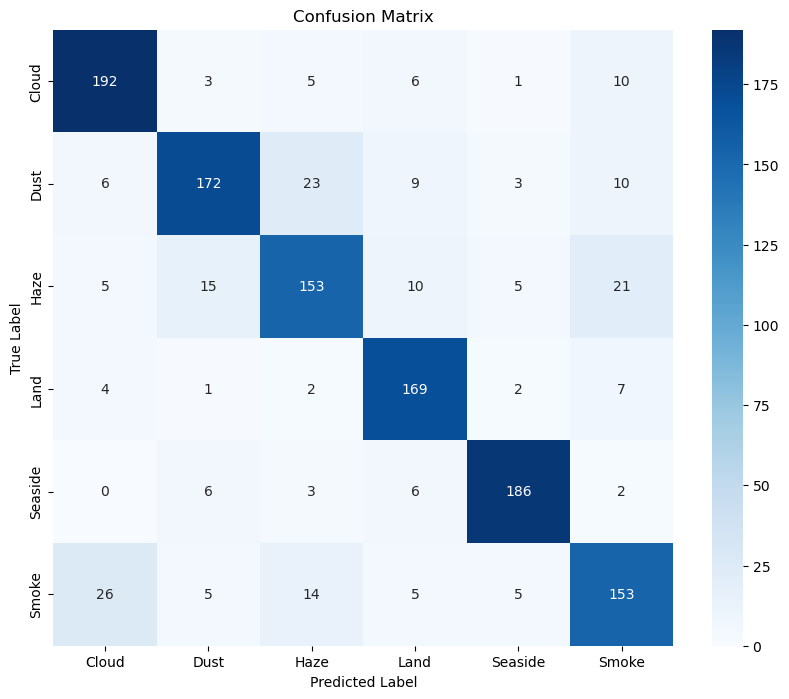

In [7]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = list(test.class_indices.keys())
confusion_matrix = confusion_matrix(pred, y_true)


plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [8]:
n_classes = len(class_labels)
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)

metrics = ['Precision', 'Recall', 'F1-score', 'False Negative Rate']

df_metrics = pd.DataFrame(index=metrics, columns=class_labels)

for i in range(n_classes):
    df_metrics.iloc[0, i] = TP[i] / (TP[i] + FP[i])
    df_metrics.iloc[1, i] = TP[i] / (TP[i] + FN[i])
    df_metrics.iloc[2, i] = 2 * TP[i] / (2 * TP[i] + FP[i] + FN[i])
    df_metrics.iloc[3, i] = FN[i] / (FN[i] + TP[i])  # False Negative Rate

def round_fn(input): 
    return round(input, 4)

df_metrics = df_metrics.map(round_fn)
df_metrics

,Cloud,Dust,Haze,Land,Seaside,Smoke
Precision,0.8240,0.8515,0.7650,0.8244,0.9208,0.7537
Recall,0.8848,0.7713,0.7321,0.9135,0.9163,0.7356
F1-score,0.8533,0.8094,0.7482,0.8667,0.9185,0.7445
False Negative Rate,0.1152,0.2287,0.2679,0.0865,0.0837,0.2644


In [9]:
from sklearn.metrics import accuracy_score

print(f'Accuracy Score: {accuracy_score(pred, y_true):.4f}')
for index, row in df_metrics.iterrows(): 
    row_mean = row.mean()
    print(f'Average {index} Score: {row_mean:.4f}')

Accuracy Score: 0.8233
Average Precision Score: 0.8232
Average Recall Score: 0.8256
Average F1-score Score: 0.8234
Average False Negative Rate Score: 0.1744


In [10]:
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('global_average_pooling2d').output)
feature_extractor_pred = feature_extractor.predict(X_test)

39/39 ━━━━━━━━━━━━━━━━━━━━ 57s 968ms/step


In [19]:
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
feature_extractor_pred = scaler.fit_transform(feature_extractor_pred)
feature_extractor_df = pd.DataFrame(feature_extractor_pred)
y_true_series = pd.Series(y_true)

In [1]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, random_state= 1, perplexity= 30, max_iter = 1000)
X_tsne_2d = tsne.fit_transform(feature_extractor_df)

plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x=X_tsne_2d[:, 0], y=X_tsne_2d[:, 1], hue=y_true, palette='viridis')
label_dict = {i: label for i, label in enumerate(class_labels)}

new_labels = [label_dict[int(item.get_text())] for item in scatter.legend_.texts]
for t, l in zip(scatter.legend_.texts, new_labels):
    t.set_text(l)

plt.title('t-SNE visualization of extracted features')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.tight_layout()
plt.show()

NameError: name 'feature_extractor_df' is not defined

In [2]:
tsne = TSNE(n_components=3, random_state=1, perplexity=30, max_iter =1000)
X_tsne_3d = tsne.fit_transform(feature_extractor_df)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2], c=y_true, cmap='viridis')
ax.set_xlabel('t-SNE feature 1')
ax.set_ylabel('t-SNE feature 2')
ax.set_zlabel('t-SNE feature 3')
ax.set_title('3D t-SNE visualization of extracted features')

cbar = plt.colorbar(scatter)
cbar.set_ticks(range(len(class_labels)))
cbar.set_ticklabels(class_labels)

plt.tight_layout()
plt.show()

NameError: name 'feature_extractor_df' is not defined

In [3]:
import plotly.express as px

df = pd.DataFrame({
    'tsne-1': X_tsne_3d[:, 0],
    'tsne-2': X_tsne_3d[:, 1],
    'tsne-3': X_tsne_3d[:, 2],
    'class': [class_labels[i] for i in y_true]
})

fig = px.scatter_3d(df, x='tsne-1', y='tsne-2', z='tsne-3',
                    color='class', 
                    title='Interactive 3D t-SNE visualization of extracted features',
                    labels={'tsne-1': 't-SNE feature 1', 
                            'tsne-2': 't-SNE feature 2', 
                            'tsne-3': 't-SNE feature 3'},
                    hover_data=['class'])

fig.update_traces(marker=dict(size=5))
fig.update_layout(legend=dict(itemsizing='constant'))
fig.show()

NameError: name 'pd' is not defined